In [1]:
import numpy as np
import lsst.daf.butler as dafButler
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

In [2]:
collections = ["LATISS/runs/AUXTEL_DRP_IMAGING_2023-11A-10A-09AB-08ABC-07AB-05AB/w_2023_46/PREOPS-4553", "LATISS/runs/AUXTEL_DRP_IMAGING_2023-09A-08ABC-07AB-05AB/d_2023_09_25/PREOPS-3780"]
#collections = [sys.argv[1], sys.argv[2]] 

In [3]:
def make_error_boxes(ax, xdata, ydata, xerror, yerror, facecolor='k', edgecolor='none', alpha=1):
    ## This function just draws in boxes in the shapes of the defects.

    # Loop over data points; create box from errors at each point
    errorboxes = [Rectangle((x, y), xe, ye, rotation_point='center')
                  for x, y, xe, ye in zip(xdata, ydata, xerror, yerror)]

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes, facecolor=facecolor, alpha=alpha,
                         edgecolor=edgecolor)

    # Add collection to axes
    ax.add_collection(pc)

    # Plot errorbars
    artists = ax.errorbar(xdata+0.5*xerror, ydata+0.5*yerror, xerr=0.5*xerror, yerr=0.5*yerror,
                          fmt='none', ecolor='k')

    return artists

def ccd_to_amps(calib):
    amps = []
    for i in range(2):
        for j in range(8):
            amps.append(calib[i*y_size:(i+1)*y_size,j*x_size:(j+1)*x_size])
    amps = np.array(amps)
    return amps
def mean(amp):
    mean = np.zeros(len(amp))
    for i in range(len(amp)):
        mean[i] = np.mean(amp[i])
    return mean

def amps_to_ccd(amps_value):
    ccd = np.zeros((4000,4072))
    for i in range(2):#=16
        for j in range(8):
            ccd[i*2000:(i+1)*y_size, j*x_size:(j+1)*x_size] = amps_value[(i+1)*j]
    return ccd

In [4]:
cd ../save_load_collections_pckgs/

/sdf/data/rubin/user/amouroux/comissioning/AuxTel/calibration_collections/save_load_collections_pckgs


In [5]:
inpath = "/sdf/home/a/amouroux/rubin-user/comissioning/AuxTel/calibration_collections/save_load_collections_pckgs/"
calibs = []
for i in range(2):
    with open(f"{collections[i].split('/')[-1]}_data_calibration.pkl", 'rb') as fichier:
        calibs.append(pickle.load(fichier))

In [6]:
calib_diff = {"calib_type":[],"calib_data_diff":[], "calib_data_frac":[]}
if len(calibs[0]["calib_type"]) > len(calibs[1]["calib_type"]):
    n_var_max = len(calibs[0]["calib_type"])
    ref_cal = calibs[0]["calib_type"]
    print(ref_cal, calibs[1]["calib_type"])
elif len(calibs[0]["calib_type"]) < len(calibs[1]["calib_type"]):
    n_var_max = len(calibs[1]["calib_type"])
    ref_cal = calibs[1]["calib_type"]
    print(ref_cal, calibs[0]["calib_type"])
else : 
    n_var_max = len(calibs[0]["calib_type"])
    ref_cal = calibs[0]["calib_type"]
    
for type in ref_cal:
    if type in calibs[0]["calib_type"] and type in calibs[1]["calib_type"] :
        calib_diff["calib_type"].append(type)
    else :
        print(f"{type} not in both calibration collections")

['flat-i' 'flat-r' 'flat-g' 'defects' 'dark' 'bias' 'crosstalk'] ['crosstalk' 'flat-r' 'flat-i' 'flat-g' 'dark' 'bias']
defects not in both calibration collections


In [7]:
x_size, y_size = 509, 2000

In [8]:
for type in calib_diff["calib_type"]:
    calib1 = calibs[0]["calib_data"][np.where(calibs[0]["calib_type"]==type)[0][0]]
    calib2 = calibs[1]["calib_data"][np.where(calibs[1]["calib_type"]==type)[0][0]]
    if type!="defects" and type!="crosstalk":
        if type !="crosstalk":
            calib1 = mean(ccd_to_amps(calib1))
            calib2 = mean(ccd_to_amps(calib2))
        diff = calib1-calib2
        frac = calib1/calib2
        diff = amps_to_ccd(diff)
        frac = amps_to_ccd(frac)
    else:
        diff = [calib1, calib2]
        frac = [calib1, calib2]
    calib_diff["calib_data_diff"].append(diff)
    calib_diff["calib_data_frac"].append(frac)

In [9]:
range_dict = {"calib_type" : ["flat", "defects", "dark", "bias", "crosstalk"], "range" : [(0.9,1.1), (0,1), (-0.1,0.1), (-4,4), (0,0.0005)]}
#range_dict = {"calib_type" : ["flat", "defects", "dark", "bias", "crosstalk"], "range" : [[(0.9,1.1), (0,1), (-0.1,0.1), (-4,4), (0,0.0005)], [(0.9,1.1), (0,1), (-0.1,0.1), (-4,4), (0,0.0005)]]}
range_dict = {"calib_type" : ["flat", "defects", "dark", "bias", "crosstalk"], "range" : [(-.1,.1), (0.9,1.1)]}
print(range_dict)
##First diff plot 

print("now plotting amp diff and frac....")
n_lignes = len(calib_diff["calib_type"])

ops = ["calib_data_diff", "calib_data_frac"]

{'calib_type': ['flat', 'defects', 'dark', 'bias', 'crosstalk'], 'range': [(-0.1, 0.1), (0.9, 1.1)]}
now plotting amp diff and frac....


crosstalk!
crosstalk!


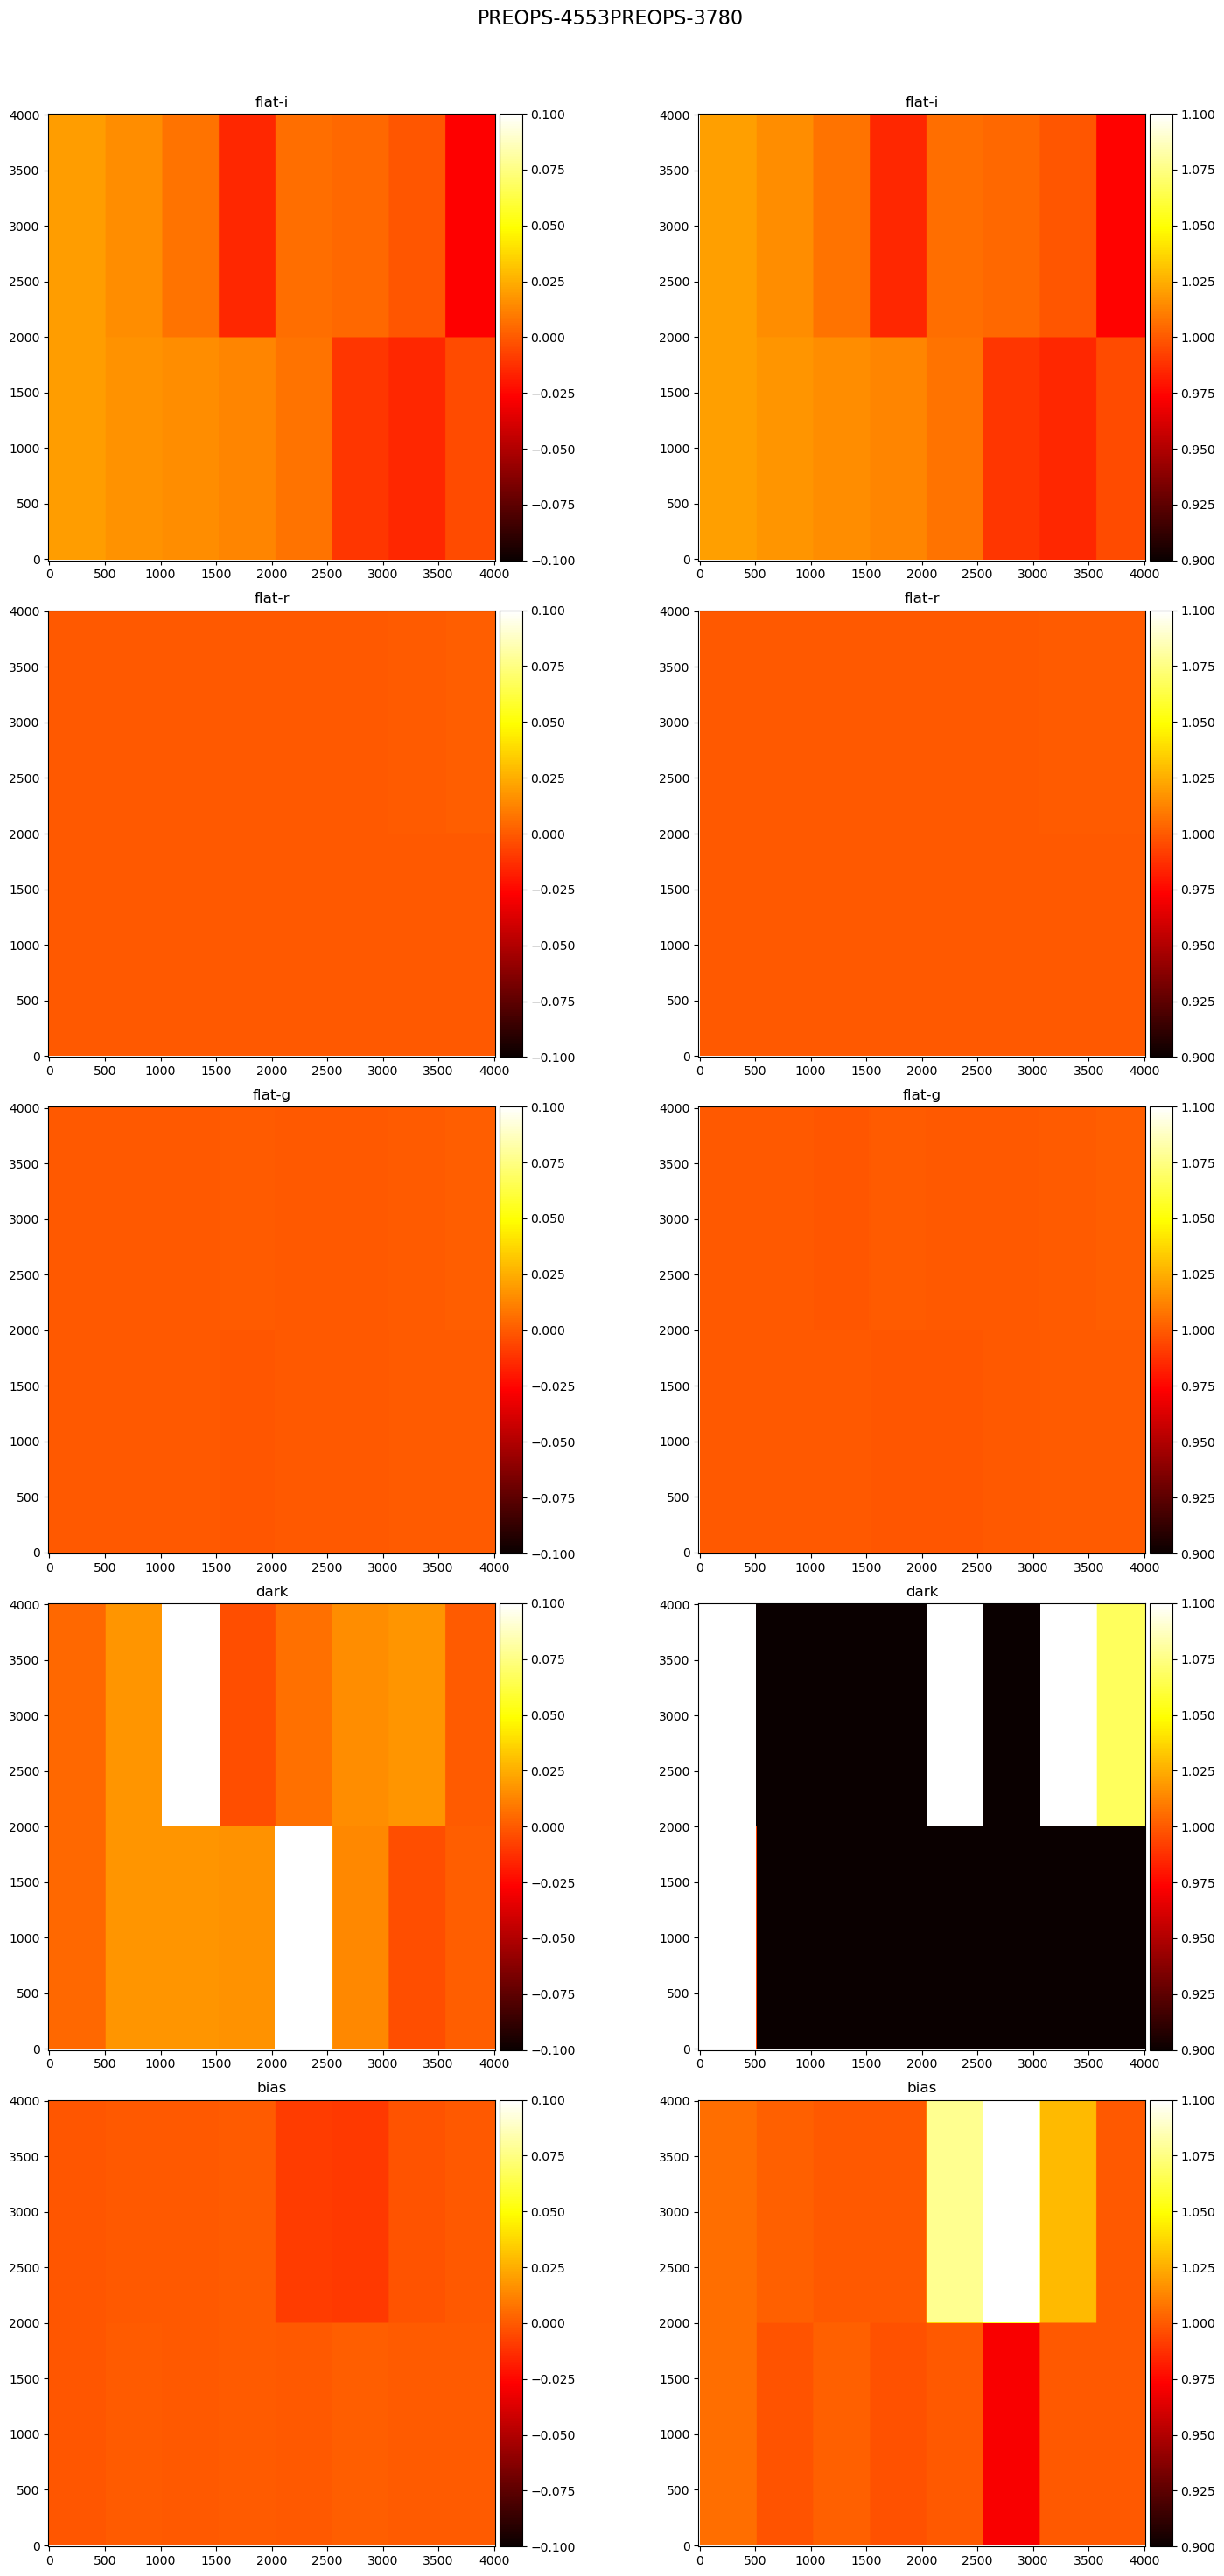

In [10]:
fig, axs = plt.subplots(n_lignes-1,2, figsize=(15,30))
ax_l = [ax for ax in axs.flat]
for j, operation in enumerate(ops): #For diff + frac
    for i in range(len(calib_diff["calib_type"])):
        #vmin, vmax = range_dict["range"][j][range_dict["calib_type"].index(calib_diff['calib_type'][i].split('-')[0])]
        vmin, vmax = range_dict["range"][j]
        if calib_diff['calib_type'][i] != "crosstalk":
            if calib_diff['calib_type'][i] != "defects" :
                im = axs[i][j].imshow(calib_diff[operation][i], cmap='hot', vmin = vmin, vmax = vmax)
                divider = make_axes_locatable(axs[i][j])
                cax = divider.append_axes('right', size='5%', pad=0.05)
                fig.colorbar(im, cax=cax, orientation='vertical')
            else :
                print("defects!")
                _ = make_error_boxes(axs[i][j], calib[j]['calib_data'][i]['x0'], calib[j]['calib_data'][i]['y0'], calib[j]['calib_data'][i]['width'], calib[j]['calib_data'][i]['height'])
                [axs[i][j].axhline(l, lw=0.1, c='k') for l in np.linspace(0,4000,3)]
                [axs[i][j].axvline(l, lw=0.1, c='k') for l in np.linspace(0,4000,9)]
            axs[i][j].set_xlim(-10,4010)
            axs[i][j].set_ylim(-10,4010)
            axs[i][j].set_aspect('equal')
            axs[i][j].set_title(calib_diff['calib_type'][i])
        else:
            print("crosstalk!")
            """
            im = axs[i][j].imshow(calib_diff[operation][j][i], vmin = vmin, vmax = vmax)
            axs[i][j].set_title('crosstalk')
            divider = make_axes_locatable(axs[i][j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            amp_l = [f"C0{i}" for i in range(8)] + [f"C1{i}" for i in range(8)]
            ticks = [i for i in range(16)]
            axs[i][j].set_xticks(ticks = ticks, labels = amp_l, fontsize = 9)
            axs[i][j].set_yticks(ticks = ticks, labels = amp_l, fontsize = 9)
            axs[i][j].set_xlabel("Victim amplifier")
            axs[i][j].set_ylabel("Source amplifier")
            fig.colorbar(im, cax=cax, orientation='vertical')
            """
fig.suptitle((collections[0].split('/')[-1] + collections[1].split('/')[-1]), fontsize = 16)
#fig.subplots_adjust(hspace=0.50)
fig.tight_layout()
fig.subplots_adjust(top=0.94)

In [14]:
calib_diff["calib_type"][0], calib_diff["calib_data_frac"][0]

('flat-i',
 array([[1.02036382, 1.02036382, 1.02036382, ..., 0.99593919, 0.99593919,
         0.99593919],
        [1.02036382, 1.02036382, 1.02036382, ..., 0.99593919, 0.99593919,
         0.99593919],
        [1.02036382, 1.02036382, 1.02036382, ..., 0.99593919, 0.99593919,
         0.99593919],
        ...,
        [1.02036382, 1.02036382, 1.02036382, ..., 0.97420966, 0.97420966,
         0.97420966],
        [1.02036382, 1.02036382, 1.02036382, ..., 0.97420966, 0.97420966,
         0.97420966],
        [1.02036382, 1.02036382, 1.02036382, ..., 0.97420966, 0.97420966,
         0.97420966]]))

In [12]:
calib_diff

{'calib_type': ['flat-i', 'flat-r', 'flat-g', 'dark', 'bias', 'crosstalk'],
 'calib_data_diff': [array([[ 0.01987457,  0.01987457,  0.01987457, ..., -0.00401759,
          -0.00401759, -0.00401759],
         [ 0.01987457,  0.01987457,  0.01987457, ..., -0.00401759,
          -0.00401759, -0.00401759],
         [ 0.01987457,  0.01987457,  0.01987457, ..., -0.00401759,
          -0.00401759, -0.00401759],
         ...,
         [ 0.01987457,  0.01987457,  0.01987457, ..., -0.02670503,
          -0.02670503, -0.02670503],
         [ 0.01987457,  0.01987457,  0.01987457, ..., -0.02670503,
          -0.02670503, -0.02670503],
         [ 0.01987457,  0.01987457,  0.01987457, ..., -0.02670503,
          -0.02670503, -0.02670503]]),
  array([[-4.64439392e-04, -4.64439392e-04, -4.64439392e-04, ...,
          -1.94907188e-05, -1.94907188e-05, -1.94907188e-05],
         [-4.64439392e-04, -4.64439392e-04, -4.64439392e-04, ...,
          -1.94907188e-05, -1.94907188e-05, -1.94907188e-05],
         